# NLP Group Project
### Alberto Puentes, Parker Voit, Tyler Applegate
#### Florence Cohort, 2021_08_03

In [1]:
# general imports
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import re
import numpy as np
import pandas as pd
import markdown 
import nltk
import csv

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

# our function modules
import acquire
import prepare

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



## Project Overview

## Key Findings:
- We found that our [**model**] outperformed all other models, including the baseline. 
- This model achieved [**percent**] overall accuracy on our training data, [**percent**] on our validate set, and finally [**percent**] on the unseen test data set.
- With more time, we would like to explore [**Hawaii, Portugal, and New Zealand**]

## Data Acquisition

In [2]:
# use our function to pull in raw data
repo_df = acquire.get_github_data(cached = True)

In [3]:
acquire.overview(repo_df)

This dataframe has 120 rows and 3 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             120 non-null    object
 1   language         120 non-null    object
 2   readme_contents  119 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB
None
----------------------------------

Unique value counts of each column

repo               120
language             4
readme_contents    119
dtype: int64
----------------------------------

Stats on Numeric Columns

                                  repo language  \
count                              120      120   
unique                             120        4   
top     /detailyang/awesome-cheatsheet     HTML   
freq                                 1       30   

                                          readme_contents  
count          

### Data Acquisition - Key Findings & Takeaways:
- We are looking at 120 observations, evenly distributed across 4 programming languages
- There appears to be 1 null value
- There are also multiple files that are in foreign languages
- For our first iteration, we are going to drop the null value, and foreign language repos

## Data Preparation

In [4]:
# perform our inital data prep and look at key stats
df = prepare.prep_article_data(repo_df, 'language', tokenizer=prepare.tokenize)
acquire.overview(df)

This dataframe has 102 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 119
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   repo                 102 non-null    object
 1   language             102 non-null    object
 2   readme_contents      102 non-null    object
 3   cleaned_language     102 non-null    object
 4   stemmed_language     102 non-null    object
 5   lemmatized_language  102 non-null    object
dtypes: object(6)
memory usage: 5.6+ KB
None
----------------------------------

Unique value counts of each column

repo                   102
language                 4
readme_contents        102
cleaned_language         4
stemmed_language         4
lemmatized_language      4
dtype: int64
----------------------------------

Stats on Numeric Columns

                            repo language  \
count                     

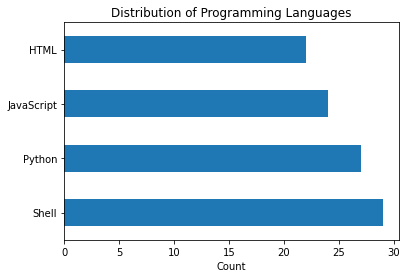

In [9]:
# visualize distribution of target variable

df.language.value_counts().plot.barh()
plt.title('Distribution of Programming Languages')
plt.xlabel("Count")
plt.show()

In [7]:
# split our data prior to exploration, stratifying on target variable 'language'
train, validate, test = prepare.train_validate_test_split(df, 'language')

In [11]:
# what does our training set look like?
acquire.overview(train)

This dataframe has 56 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 86 to 3
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   repo                 56 non-null     object
 1   language             56 non-null     object
 2   readme_contents      56 non-null     object
 3   cleaned_language     56 non-null     object
 4   stemmed_language     56 non-null     object
 5   lemmatized_language  56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB
None
----------------------------------

Unique value counts of each column

repo                   56
language                4
readme_contents        56
cleaned_language        4
stemmed_language        4
lemmatized_language     4
dtype: int64
----------------------------------

Stats on Numeric Columns

                           repo language  \
count                        56     

### Data Preparation - Key Findings & Takeaways:

## Data Exploration

### Data Exploration - Key Findings & Takeaways:

## Model Building

### Model Building - Key Findings & Takeaways:

## Model Evaluation

### Model Evaluation - Key Findings & Takeaways:

## Final Conclusions & Next Steps